In [1]:
%load_ext autoreload
%autoreload 2
from transformer import SpeechTransformer
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from custom_dataset import SpectrogramDataset, create_sampler
from training_pipeline import repeat_training, set_seed, worker_init_fn, plot_results
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Fixed values

In [2]:
SEED = 42
set_seed(SEED)
repetitions = 4
lr = 0.001
epochs = 100
tolerance = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# architecture
d_model = 128
nhead = 8
num_layers = 2

## Loading data

In [3]:
data_path = "data/train/audio_transformed"
train_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TRAIN, augmentation=True)
val_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.VAL)
test_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TEST)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1024
n_workers = 4
prefetch_factor = 2 if n_workers > 0 else None
persistent_workers = True if n_workers > 0 else False

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)

## Dropout

In [4]:
def init_transformer_dropout(dropout):
     return SpeechTransformer(num_classes=11, dropout=dropout, d_model=d_model, nhead=nhead, num_layers=num_layers)

set_seed(SEED)

optimal_alpha = 1
sampler = create_sampler(train_dataset, optimal_alpha)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor,persistent_workers=persistent_workers, worker_init_fn=worker_init_fn)

dropouts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
for dropout in dropouts:
    model_dir = f"output/models/all_classes/transformer/dropout/dropout={dropout}"
    history_dir = f"output/history/all_classes/transformer/dropout/dropout={dropout}"
    
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(history_dir, exist_ok=True)
    
    model_path = model_dir + "/transformer.pth"
    history_path = history_dir + "/transformer.pkl"
    
    repeat_training(repetitions, init_transformer_dropout, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance, dropout=dropout)

training iteration: 1 of 4
starting training...
epoch: 1, training loss: 0.0023688925094750846, training accuracy: 12.411916692765425, training balanced accuracy: 12.450019178141845
epoch: 1, validation loss: 0.002466764229821892, validation accuracy: 5.9870550161812295, validation balanced accuracy: 14.320864888518539
model saved

epoch: 2, training loss: 0.0022302191206328443, training accuracy: 17.08620419668024, training balanced accuracy: 17.163542523031335
epoch: 2, validation loss: 0.002511252056468617, validation accuracy: 6.56075316269491, validation balanced accuracy: 15.821155738483162

epoch: 3, training loss: 0.0021826970588440364, training accuracy: 19.256968368305667, training balanced accuracy: 19.154328822391715
epoch: 3, validation loss: 0.0024462423102930737, validation accuracy: 8.13474551338629, validation balanced accuracy: 19.77045487300309
model saved

epoch: 4, training loss: 0.002108750879447213, training accuracy: 22.77834325086126, training balanced accuracy

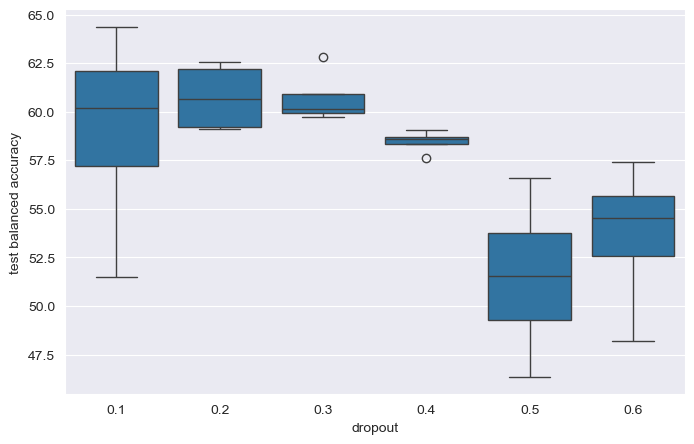

In [5]:
dropout_root_dir = "output/history/all_classes/transformer/dropout"
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
x_label = "dropout"
plot_results(dropout_root_dir, dropouts, x_label, use_balanced_accuracy=True)


## Weight decay

In [6]:
optimal_dropout = 0.2
def init_transformer_weight_decay():
    return SpeechTransformer(num_classes=11, dropout=optimal_dropout, d_model=d_model, nhead=nhead, num_layers=num_layers)

set_seed(SEED)

optimal_alpha = 1
sampler = create_sampler(train_dataset, optimal_alpha)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor,persistent_workers=persistent_workers, worker_init_fn=worker_init_fn)

weight_decays = [0.0, 0.00001, 0.0001, 0.001]
for weight_decay in weight_decays:
    model_dir = f"output/models/all_classes/transformer/weight_decay/weight_decay={weight_decay}"
    history_dir = f"output/history/all_classes/transformer/weight_decay/weight_decay={weight_decay}"
    
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(history_dir, exist_ok=True)
    
    model_path = model_dir + "/transformer.pth"
    history_path = history_dir + "/transformer.pkl"
    
    repeat_training(repetitions, init_transformer_weight_decay, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance, weight_decay=weight_decay)

training iteration: 1 of 4
starting training...
epoch: 1, training loss: 0.00236842059114679, training accuracy: 12.300344503601629, training balanced accuracy: 12.341898996972397
epoch: 1, validation loss: 0.0024608753119612064, validation accuracy: 6.031185642836128, validation balanced accuracy: 14.403250880315799
model saved

epoch: 2, training loss: 0.002227979928320417, training accuracy: 17.11360789226433, training balanced accuracy: 17.186193879834143
epoch: 2, validation loss: 0.002559432249694896, validation accuracy: 7.016769638128862, validation balanced accuracy: 16.879495299614206

epoch: 3, training loss: 0.0021798629634551332, training accuracy: 19.092546194801127, training balanced accuracy: 18.991196624215064
epoch: 3, validation loss: 0.0025068986552643333, validation accuracy: 7.619888202412474, validation balanced accuracy: 18.48029713985901

epoch: 4, training loss: 0.0021187584069019346, training accuracy: 22.097165674913875, training balanced accuracy: 22.171000

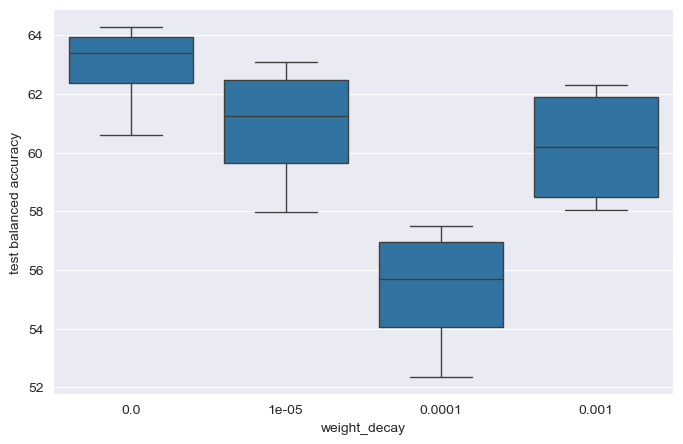

In [7]:
weight_decay_root_dir = "output/history/all_classes/transformer/weight_decay"
weight_decays = [0.0, 0.00001, 0.0001, 0.001]
x_label = "weight_decay"
plot_results(weight_decay_root_dir, weight_decays, x_label, use_balanced_accuracy=True)

## Augmented fraction

In [8]:
optimal_alpha = 1
optimal_dropout = 0.2
optimal_weight_decay = 0.0

def init_transformer_augmented_fraction():
    return SpeechTransformer(num_classes=11, dropout=optimal_dropout, d_model=d_model, nhead=nhead, num_layers=num_layers)

set_seed(SEED)

augmented_fractions = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for augmented_fraction in augmented_fractions:
    model_dir = f"output/models/all_classes/transformer/augmented_fraction/augmented_fraction={augmented_fraction}"
    history_dir = f"output/history/all_classes/transformer/augmented_fraction/augmented_fraction={augmented_fraction}"
    
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(history_dir, exist_ok=True)
    
    model_path = model_dir + "/transformer.pth"
    history_path = history_dir + "/transformer.pkl"
    
    train_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TRAIN, augmentation=True, augmented_fraction=augmented_fraction)
    sampler = create_sampler(train_dataset, optimal_alpha)
    train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor,persistent_workers=persistent_workers, worker_init_fn=worker_init_fn)
    
    repeat_training(repetitions, init_transformer_augmented_fraction, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance, weight_decay=optimal_weight_decay)

training iteration: 1 of 4
starting training...
epoch: 1, training loss: 0.0023250737245875093, training accuracy: 14.874334481678671, training balanced accuracy: 14.919006593361232
epoch: 1, validation loss: 0.0024659390939127247, validation accuracy: 8.39952927331568, validation balanced accuracy: 20.053939137225964
model saved

epoch: 2, training loss: 0.0021469085064570507, training accuracy: 20.813106796116504, training balanced accuracy: 20.92240712962787
epoch: 2, validation loss: 0.002410901508179788, validation accuracy: 9.443954104148279, validation balanced accuracy: 22.6359284225922
model saved

epoch: 3, training loss: 0.0020395930806297964, training accuracy: 26.10202004384591, training balanced accuracy: 25.940003877910662
epoch: 3, validation loss: 0.0023408846737322086, validation accuracy: 12.606649014416005, validation balanced accuracy: 28.420454018336866
model saved

epoch: 4, training loss: 0.0019047862981092284, training accuracy: 31.08949264015033, training bala

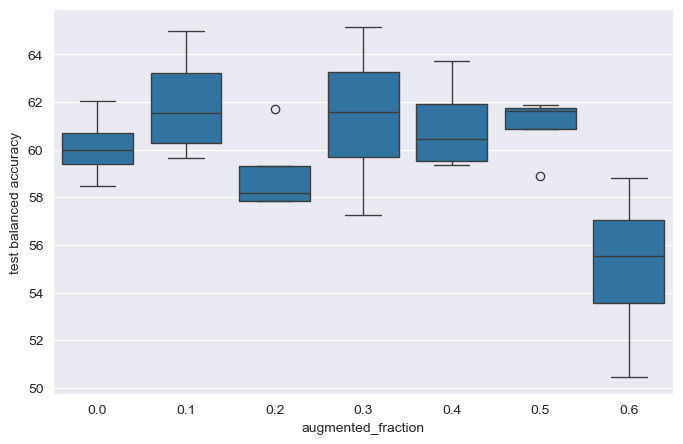

In [9]:
augmented_fraction_root_dir = "output/history/all_classes/transformer/augmented_fraction"
augmented_fractions = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
x_label = "augmented_fraction"
plot_results(augmented_fraction_root_dir, augmented_fractions, x_label, use_balanced_accuracy=True)

## Label smoothing

In [10]:
optimal_alpha = 1
optimal_dropout = 0.2
optimal_weight_decay = 0.0
optimal_augmented_fraction = 0.3

def init_transformer_label_smoothing():
    return SpeechTransformer(num_classes=11, dropout=optimal_dropout, d_model=d_model, nhead=nhead, num_layers=num_layers)

set_seed(SEED)

train_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TRAIN, augmentation=True, augmented_fraction=optimal_augmented_fraction)
sampler = create_sampler(train_dataset, optimal_alpha)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor,persistent_workers=persistent_workers, worker_init_fn=worker_init_fn)

label_smoothing_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

for label_smoothing in label_smoothing_list:
    model_dir = f"output/models/all_classes/transformer/label_smoothing/label_smoothing={label_smoothing}"
    history_dir = f"output/history/all_classes/transformer/label_smoothing/label_smoothing={label_smoothing}"
    
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(history_dir, exist_ok=True)
    
    model_path = model_dir + "/transformer.pth"
    history_path = history_dir + "/transformer.pkl"
    
    repeat_training(repetitions, init_transformer_label_smoothing, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance, weight_decay=optimal_weight_decay)

training iteration: 1 of 4
starting training...
epoch: 1, training loss: 0.002368420572479504, training accuracy: 12.300344503601629, training balanced accuracy: 12.341898996972397
epoch: 1, validation loss: 0.0024608765745485627, validation accuracy: 6.031185642836128, validation balanced accuracy: 14.403250880315799
model saved

epoch: 2, training loss: 0.0022279854725044124, training accuracy: 17.111650485436893, training balanced accuracy: 17.1843868224994
epoch: 2, validation loss: 0.002559381044763227, validation accuracy: 7.016769638128862, validation balanced accuracy: 16.879495299614206

epoch: 3, training loss: 0.002179859211330611, training accuracy: 19.092546194801127, training balanced accuracy: 18.99149328634898
epoch: 3, validation loss: 0.002507526196252251, validation accuracy: 7.575757575757576, validation balanced accuracy: 18.374173367625534

epoch: 4, training loss: 0.0021188257118022595, training accuracy: 22.15393047290949, training balanced accuracy: 22.22759858

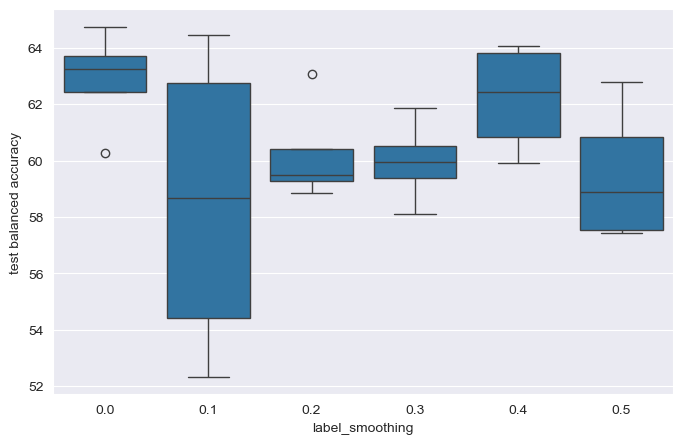

In [11]:
label_smoothing_root_dir = "output/history/all_classes/transformer/label_smoothing"
label_smoothing_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
x_label = "label_smoothing"
plot_results(label_smoothing_root_dir, label_smoothing_list, x_label, use_balanced_accuracy=True)

In [12]:
optimal_label_smoothing = 0.0